# Covid-19 Geographic Weighted Regression

Example Notebook: https://github.com/pysal/mgwr/blob/master/notebooks/MGWR_Georgia_example.ipynb <br>

Paper on GWR implementation in Python: https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwjE54yk29rtAhVQ3KQKHYgOAYgQFjACegQIAxAC&url=https%3A%2F%2Fwww.mdpi.com%2F2220-9964%2F8%2F6%2F269%2Fpdf&usg=AOvVaw1iteh4bW69F3Hzt2wsFnP4 <br>

Further reading and examples: http://methods.sagepub.com/base/download/DatasetHowToGuide/geographically-weighted-regression-berlin-districts-2018-python

In [1]:
import numpy as np
import pysal.lib as ps
from pysal.model.mgwr.gwr import GWR, MGWR
from pysal.model.mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import geopandas as gdp

C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
df = gdp.read_file('../Data/Shapefiles/AI_Covid_NUTS-Regions.shp')
print(df.columns.tolist())

['CNTR_CODE', 'ECDC_NUTS', 'NUTS_ID', 'CNTR_NAME', 'REG_NAME', 'Total_Inf', 'Amenity_Co', 'Population', 'km2', 'pop/km2', 'Amen/p1000', 'w18_infect', 'w32_infect', 'w42_infect', 'Restaurant', 'Cafe/p1000', 'FasFood/p1', 'Pup/p1000', 'Bar/p1000', 'Fuel/p1000', 'School/p10', 'Doctor/p10', 'Kinder/p10', 'w18_mTemp', 'w32_mTemp', 'An_MeanTem', 'ND_YoY_Chg', 'PM25_YoY_C', 'NMVOC_YoY_', 'PM10_YoY_C', 'geometry']


C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


<AxesSubplot:>

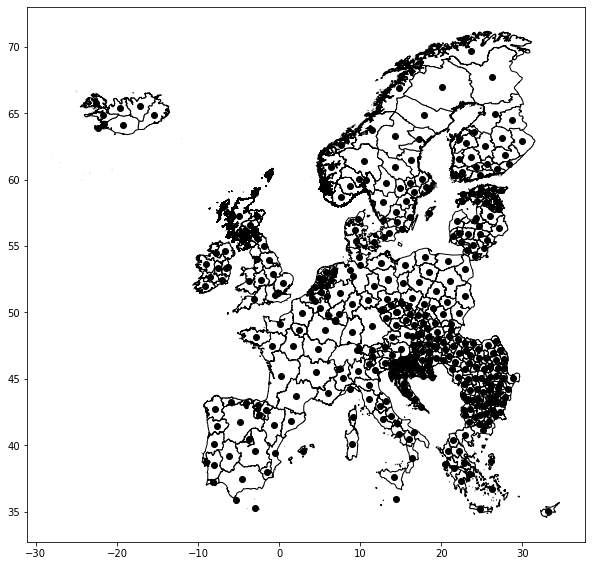

In [3]:
# Plot shapefile and feature centroids
fig, ax = plt.subplots(figsize=(10,10))
df.plot(ax=ax, **{'edgecolor':'black', 'facecolor':'white'})
df.centroid.plot(ax=ax, c='black')

In [4]:
#Prepare dataset inputs
y = df['Total_Inf'].values.reshape((-1,1)) # Dependent variables
# Select variables to include in the GWR model
X = df[['pop/km2','Restaurant', 'Cafe/p1000', 'FasFood/p1', 'Pup/p1000', 'Bar/p1000', 
                    'Fuel/p1000', 'School/p10', 'Doctor/p10', 'Kinder/p10', 'An_MeanTem', 'ND_YoY_Chg', 'PM25_YoY_C', 
                    'NMVOC_YoY_', 'PM10_YoY_C']].values

# Get all included variables, for later use in plotting
variables=df.filter(['Total_Inf','pop/km2','Restaurant', 'Cafe/p1000', 'FasFood/p1', 'Pup/p1000', 'Bar/p1000', 
                    'Fuel/p1000', 'School/p10', 'Doctor/p10', 'Kinder/p10', 'An_MeanTem', 'ND_YoY_Chg', 'PM25_YoY_C', 
                    'NMVOC_YoY', 'PM10_YoY_C','geometry'], axis=1)

# Get feature centroids
u = df.centroid.map(lambda p: p.x)
v = df.centroid.map(lambda p: p.y)

coords = list(zip(u,v))

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as app


In [5]:
#Calibrate GWR model

gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(coords, y, X, gwr_bw).fit()

104.0


In [6]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 401
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            219.230
Log-likelihood:                                                    -447.925
AIC:                                                                927.850
AICc:                                                               931.448
BIC:                                                              -2088.445
R2:                                                                   0.453
Adj. R2:                                                              0.432

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [7]:
# Filter results based on p-values (p=0.05)
filtered_estimates = gwr_results.filter_tvals()

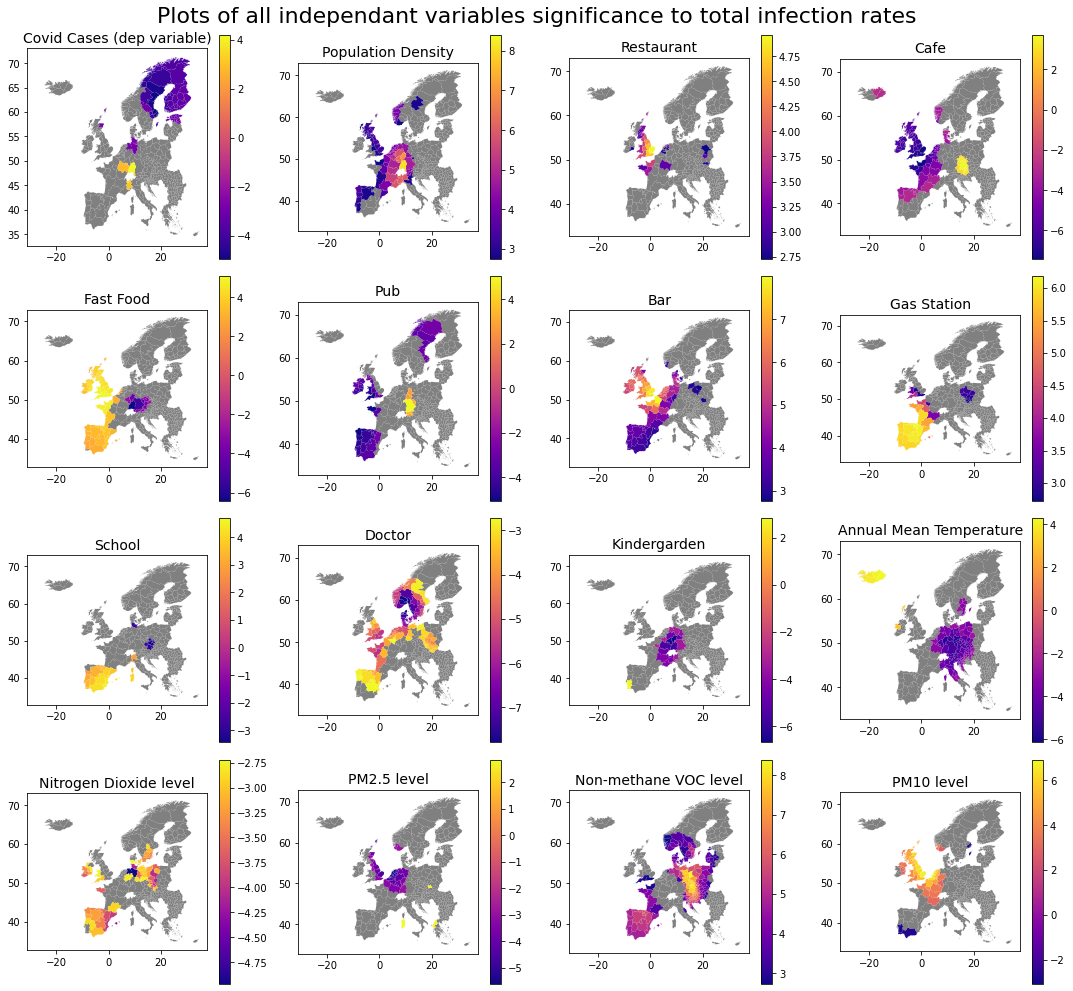

In [8]:
# Initialize a plot with 4 tiles, arranged as a 4x4 grid
f,ax = plt.subplots(4,4,figsize=(15,14), subplot_kw=dict(aspect='equal'))

ax = ax.flatten()

for i,row in enumerate(filtered_estimates.T):
    
    listings_tmp = variables.assign(toplot = filtered_estimates.T[i])
    
    listings_tmp.query('toplot == 0')\
                        .sort_values('toplot')\
                        .plot(color='grey',ax=ax[i])
    listings_tmp.query('toplot != 0')\
                        .sort_values('toplot')\
                        .plot('toplot', cmap='plasma',ax=ax[i], legend=True)
    
    ax[i].set_title(['Covid Cases (dep variable)','Population Density','Restaurant', 'Cafe', 'Fast Food', 'Pub', 'Bar', 
                    'Gas Station', 'School', 'Doctor', 'Kindergarden', 'Annual Mean Temperature', 'Nitrogen Dioxide level', 'PM2.5 level', 
                    'Non-methane VOC level', 'PM10 level'][i],fontsize=14)
    
    f.tight_layout()
    
    plt.suptitle('Plots of all independant variables significance to total infection rates', fontsize=22)
    #plt.savefig('../Output/GWR_Variable_Significance.png', dpi=300)    

Text(0.5, 1.0, 'Local R2')

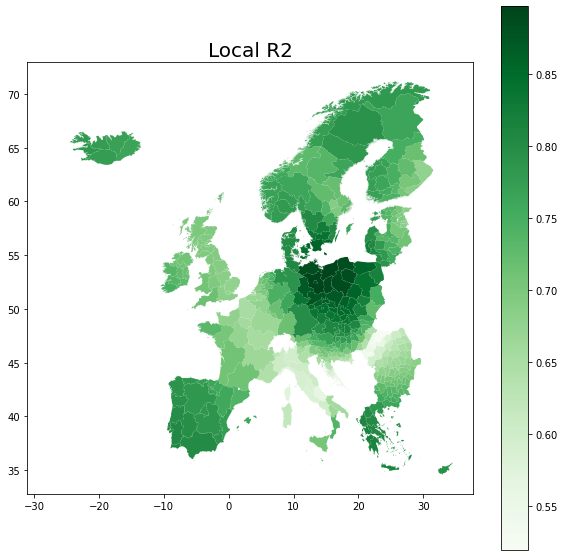

In [9]:
# Plot local R2 values

fig, ax = plt.subplots(figsize=(10,10))

#Create map with colormap stretched across range of data values
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=1))
df.assign(r2=gwr_results.localR2).sort_values('r2').plot('r2', ax=ax,cmap=sm.cmap, legend=True) 

ax.set_title('Local R2', fontsize = 20)
#plt.savefig('../Output/LocalR2_Values.png', dpi=300)

Text(0.5, 1.0, 'Standardized Residuals')

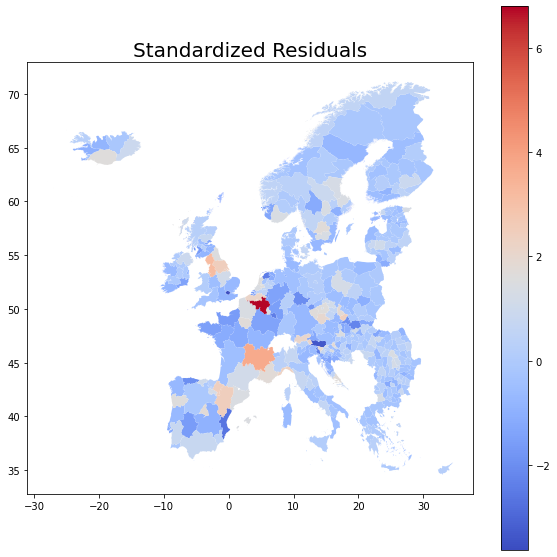

In [10]:
# Plot Residuals

fig, ax = plt.subplots(figsize=(10,10))

#Create map with colormap stretched across range of data values
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=1))
df.assign(std_res=gwr_results.std_res).sort_values('std_res').plot('std_res', ax=ax,cmap=sm.cmap, legend=True) 

ax.set_title('Standardized Residuals', fontsize = 20)
#plt.savefig('../Outputs/Standardized_Residuals.png', dpi=300)

In [11]:
LCC, VIF, CN, VDP = gwr_results.local_collinearity()

Text(0.5, 1.0, 'Condition Number')

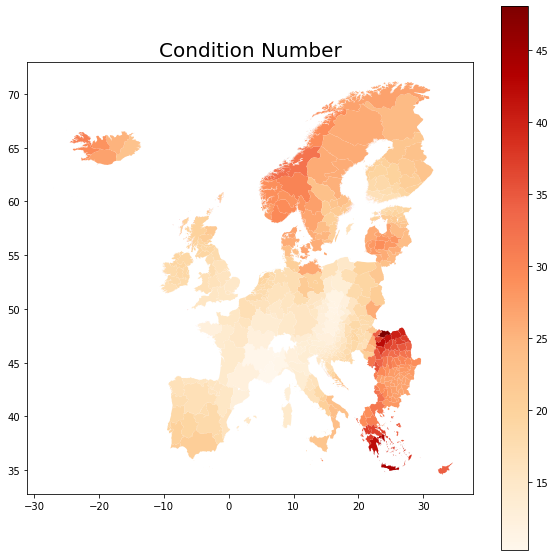

In [12]:
# Plot Condition Number

fig, ax = plt.subplots(figsize=(10,10))

#Create map with colormap stretched across range of data values
df['cn'] = CN
df.plot('cn', ax=ax,cmap='OrRd', legend=True)

ax.set_title('Condition Number', fontsize = 20)
#plt.savefig('../Output/Condition_Number.png', dpi=300)

Text(0.5, 0.98, 'Variables Coefficients')

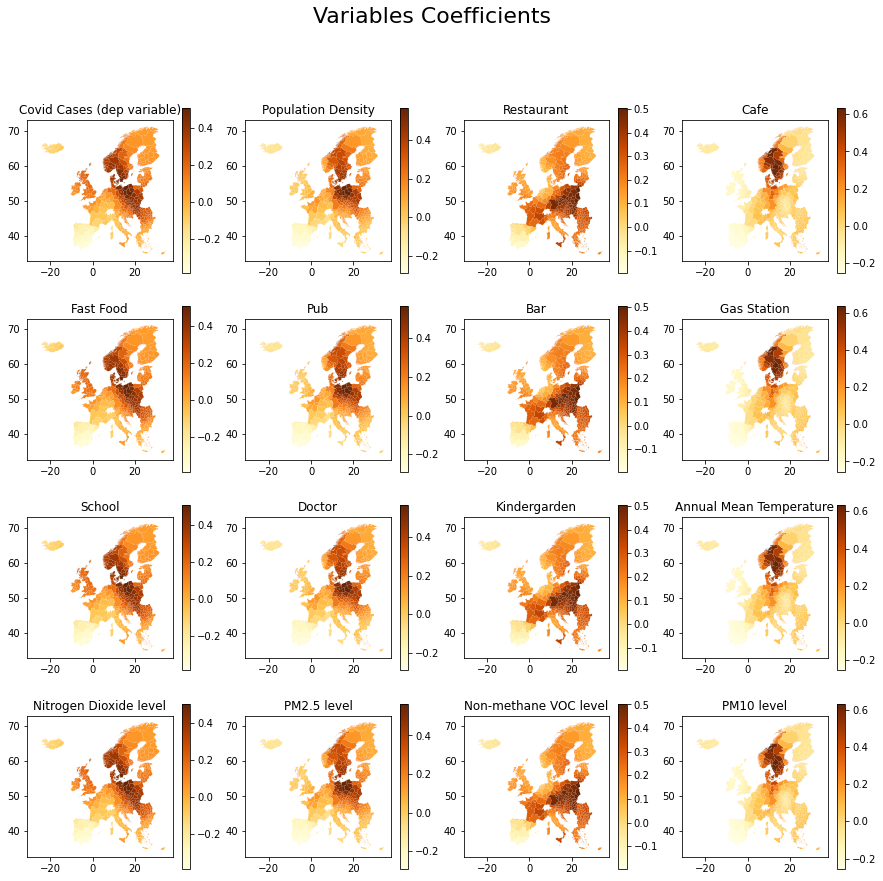

In [13]:
# Plot Coefficients
fig, ax = plt.subplots(4,4,figsize=(15,14))

name_ar = np.array([['Covid Cases (dep variable)','Population Density','Restaurant', 'Cafe'], 
                    ['Fast Food', 'Pub', 'Bar', 'Gas Station'],
                    ['School', 'Doctor', 'Kindergarden', 'Annual Mean Temperature'],
                    ['Nitrogen Dioxide level', 'PM2.5 level', 'Non-methane VOC level', 'PM10 level']], dtype=object)


#Create map with colormap stretched across range of data values
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=0, vmax=1))

for row in range(4):
    for col in range(4):
        df['vif'] = LCC[:, col]
        df.plot('vif', ax = ax[row,col],cmap=sm.cmap, legend = True)
        ax[row,col].set_title(name_ar[row,col])
        
plt.suptitle('Variables Coefficients', fontsize=22)
#plt.savefig('../Outputs/Variables_Coefficients.png', dpi=300)

## GWR Prediction

Example Notebook: https://pysal.org/notebooks/model/mgwr/GWR_prediction_example.html

In [14]:
# Load in libraries
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load shapefile
df = gpd.read_file('../Data/Shapefiles/AI_Covid_NUTS-Regions.shp')

In [17]:
#Prepare dataset inputs
y = df['Total_Inf'].values.reshape((-1,1))
X = df[['pop/km2','Restaurant', 'Cafe/p1000', 'FasFood/p1', 'Pup/p1000', 'Bar/p1000', 
                    'Fuel/p1000', 'School/p10', 'Doctor/p10', 'Kinder/p10', 'An_MeanTem', 'ND_YoY_Chg', 'PM25_YoY_C', 
                    'NMVOC_YoY_', 'PM10_YoY_C']].values

u = df.centroid.map(lambda p: p.x)
v = df.centroid.map(lambda p: p.y)
coords = list(zip(u,v))


np.random.seed(908)
sample = np.random.choice(range(401), 134)
mask = np.ones_like(y, dtype = bool).flatten()
mask[sample] = False
cal_coords = np.array(coords)[mask]
cal_y = y[mask]
cal_X = X[mask]
pred_coords = np.array(coords)[~mask]
pred_y = y[~mask]
pred_X = X[~mask]

C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
C:\Users\EG53BX\Miniconda3\envs\ai4covid\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [18]:
#Calibrate GWR model
gwr_selector = Sel_BW(cal_coords, cal_y, cal_X)
gwr_bw = gwr_selector.search(bw_min = 2)
print(gwr_bw)
model = GWR(cal_coords, cal_y, cal_X, gwr_bw)
gwr_results = model.fit()

125.0


In [19]:
#Make predictions
pred_results = model.predict(pred_coords, pred_X)

In [20]:
pred_results.predictions

array([[ 2962.64946641],
       [ -326.44644794],
       [ 3266.53471744],
       [ 6151.69095049],
       [ 5859.22119552],
       [-1807.43044263],
       [ 6275.64684992],
       [ 5064.96150777],
       [ 2541.15124162],
       [ 1220.11321507],
       [ 1978.63616639],
       [  260.37818179],
       [ 1158.87264966],
       [  796.54826902],
       [ 1982.83047067],
       [ 7127.40909988],
       [ 4245.62556681],
       [ 4727.47087768],
       [ 1263.61486438],
       [ 7377.52121654],
       [ 1394.92643347],
       [ 6145.84128315],
       [ 4200.45081581],
       [ 5120.73419335],
       [ 4850.34844984],
       [ 1696.37706183],
       [ 1515.3794392 ],
       [ 3546.03296563],
       [ 3408.84734448],
       [ 2295.15180612],
       [ 3987.25288946],
       [ 2172.33794836],
       [ 2244.6145646 ],
       [ 4178.73289176],
       [ 2494.88323966],
       [ 2430.09941233],
       [ 1523.31158158],
       [ 3028.9465517 ],
       [ 6963.05689468],
       [ 1988.07721857],


In [21]:
pred_y

array([[2.35828963e+03],
       [4.07139213e+03],
       [3.77684842e+03],
       [1.08328053e+04],
       [7.49022151e+03],
       [2.11769097e+03],
       [7.63652425e+03],
       [2.57159767e+03],
       [3.37947298e+03],
       [1.43100741e+03],
       [1.90272457e+03],
       [1.01426577e+03],
       [8.85219660e+02],
       [1.46365864e+03],
       [1.13854267e+03],
       [6.36028615e+03],
       [2.57161701e+03],
       [3.47035371e+03],
       [5.11746250e+02],
       [6.30016346e+03],
       [2.67013590e+03],
       [2.58027738e+03],
       [3.68288934e+03],
       [5.38643497e+03],
       [7.48857585e+03],
       [2.18401534e+03],
       [2.68660890e+03],
       [3.68686069e+03],
       [3.46071279e+03],
       [1.93562532e+03],
       [3.39890432e+03],
       [2.43853708e+03],
       [1.57519962e+03],
       [2.90950258e+03],
       [2.93417494e+03],
       [2.42560175e+03],
       [1.08283510e+03],
       [4.16592704e+03],
       [5.12282296e+03],
       [2.58316448e+03],


In [22]:
#Check correlation between known and predicted values
corr = np.corrcoef(pred_results.predictions.flatten(),
                   pred_y.flatten())[0][1]

print(corr)

0.7734994272563892
